# Exercise - Kernel Authoring - Copy - SOLUTION

In this exercise, we'll learn how to analyze and reason about the performance of CUDA kernels using the NVIDIA Nsight Compute profiler.

We'll look at a few different ways of writing a simple kernel that copies items from one array to another.

First, we need to make sure the Nsight Compute profiler, Nsightful, Numba CUDA, and CuPy are available in our notebook:

In [1]:
import os

if os.getenv("COLAB_RELEASE_TAG"): # If running in Google Colab:
  !curl -s -L -O https://developer.nvidia.com/downloads/assets/tools/secure/nsight-systems/2025_3/NsightSystems-linux-cli-public-2025.3.1.90-3582212.deb
  !sudo dpkg -i NsightSystems-linux-cli-public-2025.3.1.90-3582212.deb > /dev/null
  !pip install "numba-cuda" "cupy-cuda12x" "nsightful[notebook] @ git+https://github.com/brycelelbach/nsightful.git" > /dev/null 2>&1
  os.environ["NUMBA_CUDA_ENABLE_PYNVJITLINK"] = "1"

Now, we'll write our first kernel. Each thread will copy `items_per_thread` items from the `src` array to the `dst` array. We'll set the number of threads per block to a constant, `threads_per_block`. We'll calculate how many blocks to launch based on `items_per_thread` and `threads_per_block`. We use `cuda.grid(1)` to get the unique global 1D index of each thread.

Each thread will copy a contiguous set of items, e.g. the items with indices `[base, base + items_per_thread)`:

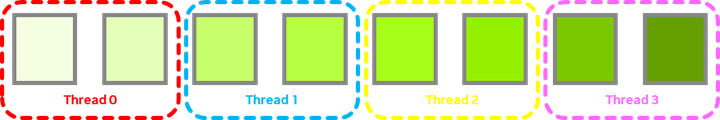

**NOTE: The next cell won't actually run any code, it will just write its contents to a file. This is necessary because we have to run the code with the Nsight Compute profiler.**

In [2]:
%%writefile copy_blocked.py

from numba import cuda
import cupy as cp
import cupyx as cpx
import sys
import os

threads_per_block = 256 if len(sys.argv) < 2 else int(sys.argv[1])
items_per_thread = 64 if len(sys.argv) < 3 else int(sys.argv[2])
total_items = 2**28 if len(sys.argv) < 4 else int(sys.argv[3])
blocks = int(total_items / (threads_per_block * items_per_thread))

src = cp.arange(total_items)
dst = cp.empty_like(src)

@cuda.jit
def copy_blocked(src, dst, items_per_thread):
 base = cuda.grid(1) * items_per_thread
 for i in range(items_per_thread):
   dst[base + i] = src[base + i]

def launch():
  copy_blocked[blocks, threads_per_block](src, dst, items_per_thread)

if os.getenv("NV_COMPUTE_PROFILER_PERFWORKS_DIR"): # Running under `ncu`.
  launch() # `ncu` slows things down; so just launch once when running under it.
else:
  D = cpx.profiler.benchmark(launch, n_repeat=15, n_warmup=1).gpu_times[0]
  print(f"{D.mean():.3g} s ± {(D.std() / D.mean()):.2%} (mean ± relative stdev of {D.size} runs)")

Writing copy_blocked.py


Next, we'll actually run the code, by invoking the Nsight Compute `ncu` command line tool. The basic syntax for this tool is `ncu <ncu flags> <your program> <your program args>`, which will run `<your program> <your program args>` while gathering a profile trace. We're passing it some flags that describe what data it should collect and where it should save the results.

There is an overhead to running code under the profiler. Your program may execute noticably slower.

When profiling and benchmarking, we need to run with a sufficient workload to get meaningful and representative results. If your runtime is too short, the profiler may not be able to report some metrics or the results may be inaccurate.

**NOTE: To modify and rerun the above code, you must execute the previous cell to write the file and this one to execute it.**

In [3]:
!ncu -f --kernel-name regex:copy_blocked --set full -o copy_blocked python copy_blocked.py
copy_blocked_csv = !ncu --import copy_blocked.ncu-rep --csv

==PROF== Connected to process 1137 (/usr/bin/python3.11)
==PROF== Profiling "copy_blocked[abi:v1,cw51cXTLSUwv1sDUaKthrqNgqqmjgOR3W3CwAkMXLaJtQYkOIgxJU0gCqOkEJoHkbttqdVhoqlspQGNFHSgJ5BnXagIA]": 0%....50%....100% - 30 passes
==PROF== Disconnected from process 1137
==PROF== Report: /content/copy_blocked.ncu-rep


Let's take a look at the profiling report on the kernel. When you run the next cell, a number of tabs will be displayed. The first tab will have a summary of all of the Nsight recommendations and advisories. Subsequent tabs will have more detailed information on a particular area.

Remember, you can see even more information in the [Nsight Compute GUI](https://developer.nvidia.com/nsight-compute).

In [4]:
import nsightful

nsightful.display_ncu_csv_in_notebook(copy_blocked_csv)

<IPython.core.display.Javascript object>

Dropdown(description='Kernel:', layout=Layout(width='400px'), options=('copy_blocked',), style=DescriptionStyl…

Output()

In our kernel, each thread linearly accesses a chunk of contiguous memory, which is what you'd want on the CPU, but not on the GPU! Our access pattern looks like this:

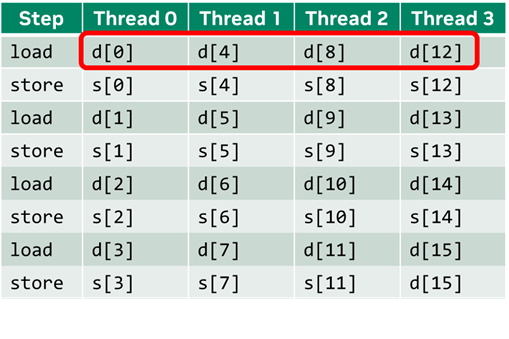

Threads are executed together in small groups called blocks. For load and store operations, if each thread in the block is operating on an array index that is nearby the array indices of the other threads, then the GPU can combine those contiguous memory operation into more efficient bulk operations. This is called memory coalescing, and it's essential for GPU performance.

This means we want each thread to access a strided chunk of memory instead, like so:

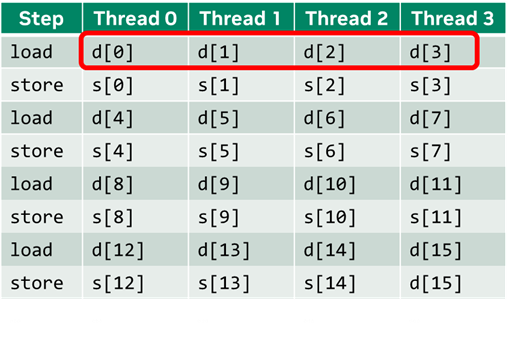

We call these access patterns blocked and striped respectively.

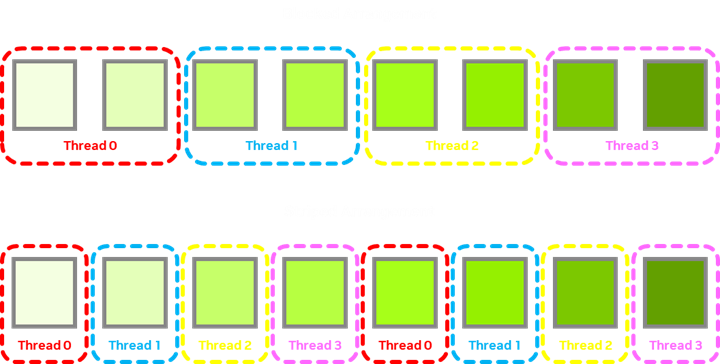

We can no longer use the `cuda.grid` utility when implementing the striped arrangement. We need to access the hierarchical coordinates of our thread to compute the right step size:

- `cuda.blockDim.x`: The number of threads per block.
- `cuda.blockIdx.x`: The global index of the current thread block.
- `cuda.threadIdx.x`: The local index of the current thread within this block.

In [5]:
%%writefile copy_optimized.py

from numba import cuda
import cupy as cp
import cupyx as cpx
import sys
import os

threads_per_block = 256 if len(sys.argv) < 2 else int(sys.argv[1])
items_per_thread = 64 if len(sys.argv) < 3 else int(sys.argv[2])
total_items = 2**28 if len(sys.argv) < 4 else int(sys.argv[3])
blocks = int(total_items / (threads_per_block * items_per_thread))

src = cp.arange(total_items)
dst = cp.empty_like(src)

@cuda.jit
def copy_optimized(src, dst, items_per_thread):
  bd = cuda.blockDim.x
  bx = cuda.blockIdx.x
  tx = cuda.threadIdx.x
  items_per_block = bd * items_per_thread

  base = tx + bx * items_per_block
  for i in range(0, items_per_block, bd):
    dst[base + i] = src[base + i]

def launch():
  copy_optimized[blocks, threads_per_block](src, dst, items_per_thread)

if os.getenv("NV_COMPUTE_PROFILER_PERFWORKS_DIR"): # Running under `ncu`.
  launch() # `ncu` slows things down; so just launch once when running under it.
else:
  D = cpx.profiler.benchmark(launch, n_repeat=15, n_warmup=1).gpu_times[0]
  print(f"{D.mean():.3g} s ± {(D.std() / D.mean()):.2%} (mean ± relative stdev of {D.size} runs)")

Writing copy_optimized.py


Before we look at the report, let's compare the execution times of both versions:

In [6]:
copy_blocked_duration   = !python copy_blocked.py
copy_optimized_duration = !python copy_optimized.py
speedup = float(copy_blocked_duration[0].split()[0]) / float(copy_optimized_duration[0].split()[0])

print(f"copy_blocked:   {copy_blocked_duration[0]}")
print(f"copy_optimized: {copy_optimized_duration[0]}")
print(f"copy_optimized speedup over copy_blocked: {speedup:.2f}")

copy_blocked:   0.327 s ± 0.66% (mean ± relative stdev of 15 runs)
copy_optimized: 0.019 s ± 0.53% (mean ± relative stdev of 15 runs)
copy_optimized speedup over copy_blocked: 17.21


That's quite a difference! Now let's profile the optimized variant:

In [7]:
!ncu -f --kernel-name regex:copy_optimized --set full -o copy_optimized python copy_optimized.py
copy_optimized_csv = !ncu --import copy_optimized.ncu-rep --csv

==PROF== Connected to process 1401 (/usr/bin/python3.11)
==PROF== Profiling "copy_optimized[abi:v1,cw51cXTLSUwv1sDUaKthrqNgqqmjgOR3W3CwAkMXLaJtQYkOIgxJU0gCqOkEJoHkbttqdVhoqlspQGNFHSgJ5BnXagIA]": 0%....50%....100% - 30 passes
==PROF== Disconnected from process 1401
==PROF== Report: /content/copy_optimized.ncu-rep


Now let's dive into the profile report:

In [8]:
nsightful.display_ncu_csv_in_notebook(copy_optimized_csv)

<IPython.core.display.Javascript object>

Dropdown(description='Kernel:', layout=Layout(width='400px'), options=('copy_optimized',), style=DescriptionSt…

Output()